# MovieLens - Predicting a user's gender based on the movies they have watched

In this notebook, we will apply getML to a dataset that is often used for benchmarking in the relational learning literature: The MovieLens dataset.

Summary:

- Prediction type: __Classification model__
- Domain: __Entertainment__
- Prediction target: __The gender of a user__ 
- Population size: __6039__

_Author: Dr. Patrick Urbanke_

# Background

The MovieLens dataset is often used in the relational learning literature has a benchmark for newly developed algorithms. Following the tradition, we benchmark getML's own algorithms on this dataset as well. The task is to predict a user's gender based on the movies they have watched.


It has been downloaded from the [CTU Prague relational learning repository](https://relational.fit.cvut.cz/dataset/MovieLens) (Motl and Schulte, 2015).

### A web frontend for getML

The getML monitor is a frontend built to support your work with getML. The getML monitor displays information such as the imported data frames, trained pipelines and allows easy data and feature exploration. You can launch the getML monitor [here](http://localhost:1709).

# Analysis

Let's get started with the analysis and set up your session:

In [1]:
import copy
import os
from urllib import request

import numpy as np
import pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline  

import getml

getml.engine.set_project('MovieLens')



Loading pipelines...
[========================================] 100%

Connected to project 'MovieLens'


## 1. Loading data

### 1.1 Download from source

We begin by downloading the data from the source file:

In [2]:
conn = getml.database.connect_mariadb(
    host="relational.fit.cvut.cz",
    dbname="imdb_MovieLens",
    port=3306,
    user="guest",
    password="relational"
)

conn

Connection(conn_id='default',
           dbname='imdb_MovieLens',
           dialect='mysql',
           host='relational.fit.cvut.cz',
           port=3306)

In [3]:
def load_if_needed(name):
    """
    Loads the data from the relational learning
    repository, if the data frame has not already
    been loaded.
    """
    if not getml.data.exists(name):
        data_frame = getml.data.DataFrame.from_db(
            name=name,
            table_name=name,
            conn=conn
        )
        data_frame.save()
    else:
        data_frame = getml.data.load_data_frame(name)
    return data_frame

In [4]:
users = load_if_needed("users")
u2base = load_if_needed("u2base")
movies = load_if_needed("movies")
movies2directors = load_if_needed("movies2directors")
directors = load_if_needed("directors")
movies2actors = load_if_needed("movies2actors")
actors = load_if_needed("actors")

### 1.2 Prepare data for getML

getML requires that we define *roles* for each of the columns.

In [5]:
users["target"] = (users.u_gender == 'F')

In [6]:
users.set_role("userid", getml.data.roles.join_key)
users.set_role("age", getml.data.roles.numerical)
users.set_role("occupation", getml.data.roles.categorical)
users.set_role("target", getml.data.roles.target)

users.save()

name,userid,target,occupation,age,u_gender
role,join_key,target,categorical,numerical,unused_string
0,1,1,2,1,F
1,51,1,2,1,F
2,75,1,2,1,F
3,86,1,2,1,F
4,99,1,2,1,F
,...,...,...,...,...
6034,5658,0,5,56,M
6035,5669,0,5,56,M
6036,5703,0,5,56,M


In [7]:
u2base.set_role(["userid", "movieid"], getml.data.roles.join_key)
u2base.set_role("rating", getml.data.roles.numerical)

u2base.save()

name,userid,movieid,rating
role,join_key,join_key,numerical
0,2,1964242,1
1,2,2219779,1
2,3,1856939,1
3,4,2273044,1
4,5,1681655,1
,...,...,...
996154,6040,2560616,5
996155,6040,2564194,5
996156,6040,2581228,5


In [8]:
movies.set_role("movieid", getml.data.roles.join_key)
movies.set_role(["year", "runningtime"], getml.data.roles.numerical)
movies.set_role(["isEnglish", "country"], getml.data.roles.categorical)

movies.save()

name,movieid,isEnglish,country,year,runningtime
role,join_key,categorical,categorical,numerical,numerical
0,1672052,T,other,3,2
1,1672111,T,other,4,2
2,1672580,T,USA,4,3
3,1672716,T,USA,4,2
4,1672946,T,USA,4,0
,...,...,...,...,...
3827,2591814,T,other,4,2
3828,2592334,T,USA,4,2
3829,2592963,F,France,2,2


In [9]:
movies2directors.set_role(["movieid", "directorid"], getml.data.roles.join_key)
movies2directors.set_role( "genre", getml.data.roles.categorical)

movies2directors.save()

name,movieid,directorid,genre
role,join_key,join_key,categorical
0,1672111,54934,Action
1,1672946,188940,Action
2,1679461,179783,Action
3,1691387,291700,Action
4,1693305,14663,Action
,...,...,...
4136,2570825,265215,Other
4137,2572478,149311,Other
4138,2577062,304827,Other


In [10]:
directors.set_role("directorid", getml.data.roles.join_key)
directors.set_role(["d_quality", "avg_revenue"], getml.data.roles.numerical)

directors.save()

name,directorid,d_quality,avg_revenue
role,join_key,numerical,numerical
0,67,4,1
1,92,2,3
2,284,4,0
3,708,4,1
4,746,4,4
,...,...,...
2196,305962,4,4
2197,305978,4,2
2198,306168,3,2


In [11]:
movies2actors.set_role(["movieid", "actorid"], getml.data.roles.join_key)
movies2actors.set_role( "cast_num", getml.data.roles.numerical)

movies2actors.save()

name,movieid,actorid,cast_num
role,join_key,join_key,numerical
0,1672580,981535,0
1,1672946,1094968,0
2,1673647,149985,0
3,1673647,261595,0
4,1673647,781357,0
,...,...,...
138344,2593313,947005,3
138345,2593313,1090590,3
138346,2593313,1347419,3


We need to separate our data set into a training, testing and validation set:

In [12]:
actors.set_role("actorid", getml.data.roles.join_key)
actors.set_role("a_quality", getml.data.roles.numerical)
actors.set_role("a_gender", getml.data.roles.categorical)

actors.save()

name,actorid,a_gender,a_quality
role,join_key,categorical,numerical
0,4,M,4
1,16,M,0
2,28,M,4
3,566,M,4
4,580,M,4
,...,...,...
98685,2749162,F,3
98686,2749168,F,3
98687,2749204,F,3


In [13]:
split = getml.data.split.random(train=0.75, test=0.25)
split

,
0,train
1,train
2,train
3,test
4,test
,...


In [14]:
container = getml.data.Container(population=users, split=split)

container.add(
    u2base=u2base,
    movies=movies,
    movies2directors=movies2directors,
    directors=directors,
    movies2actors=movies2actors,
    actors=actors,
)

container

population
    subset   name    rows   type
0   test     users   1511   View
1   train    users   4528   View

peripheral
    name                 rows   type     
0   u2base             996159   DataFrame
1   movies               3832   DataFrame
2   movies2directors     4141   DataFrame
3   directors            2201   DataFrame
4   movies2actors      138349   DataFrame
5   actors              98690   DataFrame

## 2. Predictive modeling

We loaded the data and defined the roles and units. Next, we create a getML pipeline for relational learning.

### 2.1 Define relational model

To get started with relational learning, we need to specify the data model.

In [15]:
dm = getml.data.DataModel(users.to_placeholder())

dm.add(getml.data.to_placeholder(
    u2base=u2base,
    movies=movies,
    movies2directors=movies2directors,
    directors=directors,
    movies2actors=movies2actors,
    actors=actors,
))

dm.population.join(
    dm.u2base,
    on='userid'
)

dm.u2base.join(
    dm.movies,
    on='movieid',
    relationship=getml.data.relationship.many_to_one
)

dm.movies.join(
    dm.movies2directors,
    on='movieid',
    relationship=getml.data.relationship.propositionalization
)

dm.movies2directors.join(
    dm.directors,
    on='directorid',
    relationship=getml.data.relationship.many_to_one
)

dm.movies.join(
    dm.movies2actors,
    on='movieid',
    relationship=getml.data.relationship.propositionalization
)

dm.movies2actors.join(
    dm.actors,
    on='actorid',
    relationship=getml.data.relationship.many_to_one
)

dm

,data frames,staging table
0,users,USERS__STAGING_TABLE_1
1,"movies2actors, actors",MOVIES2ACTORS__STAGING_TABLE_2
2,"movies2directors, directors",MOVIES2DIRECTORS__STAGING_TABLE_3
3,"u2base, movies",U2BASE__STAGING_TABLE_4


### 2.2 getML pipeline

<!-- #### 2.1.1  -->
__Set-up the feature learner & predictor__

We will set up two pipelines. One of them uses `FastProp`, the other one uses `Relboost`. Note that we have marked some of the joins in the data model with the `propositionalization` tag. This means that `FastProp` will be used for these relationships, even for the second pipeline. This can significantly speed up the training process.

In [16]:
mapping = getml.preprocessors.Mapping()

fast_prop = getml.feature_learning.FastProp(
    loss_function=getml.feature_learning.loss_functions.CrossEntropyLoss,
    num_threads=1,
)

relboost = getml.feature_learning.Relboost(
    loss_function=getml.feature_learning.loss_functions.CrossEntropyLoss,
    num_subfeatures=50,
    num_threads=1
)

predictor = getml.predictors.XGBoostClassifier(
    max_depth=5,
    n_jobs=1,
)

__Build the pipeline__

In [17]:
pipe1 = getml.pipeline.Pipeline(
    tags=['fast_prop'],
    data_model=dm,
    preprocessors=[mapping],
    feature_learners=[fast_prop],
    predictors=[predictor]
)

pipe1

Pipeline(data_model='users',
         feature_learners=['FastProp'],
         feature_selectors=[],
         include_categorical=False,
         loss_function=None,
         peripheral=['actors', 'directors', 'movies', 'movies2actors', 'movies2directors',
                     'u2base'],
         predictors=['XGBoostClassifier'],
         preprocessors=['Mapping'],
         share_selected_features=0.5,
         tags=['fast_prop'])

In [18]:
pipe2 = getml.pipeline.Pipeline(
    tags=['relboost'],
    data_model=dm,
    preprocessors=[mapping],
    feature_learners=[relboost],
    predictors=[predictor]
)

pipe2

Pipeline(data_model='users',
         feature_learners=['Relboost'],
         feature_selectors=[],
         include_categorical=False,
         loss_function=None,
         peripheral=['actors', 'directors', 'movies', 'movies2actors', 'movies2directors',
                     'u2base'],
         predictors=['XGBoostClassifier'],
         preprocessors=['Mapping'],
         share_selected_features=0.5,
         tags=['relboost'])

### 2.3 Model training

In [19]:
pipe1.check(container.train)

Checking data model...


Staging...
[========================================] 100%

Preprocessing...
[========================================] 100%

INFO [FOREIGN KEYS NOT FOUND]: When joining U2BASE__STAGING_TABLE_4 and MOVIES2DIRECTORS__STAGING_TABLE_3 over 'movieid' and 'movieid', there are no corresponding entries for 0.159513% of entries in 'movieid' in 'U2BASE__STAGING_TABLE_4'. You might want to double-check your join keys.
INFO [FOREIGN KEYS NOT FOUND]: When joining U2BASE__STAGING_TABLE_4 and MOVIES2ACTORS__STAGING_TABLE_2 over 'movieid' and 'movieid', there are no corresponding entries for 0.340408% of entries in 'movieid' in 'U2BASE__STAGING_TABLE_4'. You might want to double-check your join keys.


In [20]:
pipe1.fit(container.train)

Checking data model...


Staging...
[========================================] 100%

INFO [FOREIGN KEYS NOT FOUND]: When joining U2BASE__STAGING_TABLE_4 and MOVIES2DIRECTORS__STAGING_TABLE_3 over 'movieid' and 'movieid', there are no corresponding entries for 0.159513% of entries in 'movieid' in 'U2BASE__STAGING_TABLE_4'. You might want to double-check your join keys.
INFO [FOREIGN KEYS NOT FOUND]: When joining U2BASE__STAGING_TABLE_4 and MOVIES2ACTORS__STAGING_TABLE_2 over 'movieid' and 'movieid', there are no corresponding entries for 0.340408% of entries in 'movieid' in 'U2BASE__STAGING_TABLE_4'. You might want to double-check your join keys.


Staging...
[========================================] 100%

Preprocessing...
[========================================] 100%

FastProp: Trying 941 features...
[========================================] 100%

FastProp: Building subfeatures...
[========================================] 100%

FastProp: Building features...
[=====================

Pipeline(data_model='users',
         feature_learners=['FastProp'],
         feature_selectors=[],
         include_categorical=False,
         loss_function=None,
         peripheral=['actors', 'directors', 'movies', 'movies2actors', 'movies2directors',
                     'u2base'],
         predictors=['XGBoostClassifier'],
         preprocessors=['Mapping'],
         share_selected_features=0.5,
         tags=['fast_prop', 'container-AHgCFi'])

url: http://localhost:1709/#/getpipeline/MovieLens/Dook2u/0/

In [21]:
pipe2.check(container.train)

Checking data model...


Staging...
[========================================] 100%

Preprocessing...
[========================================] 100%

INFO [FOREIGN KEYS NOT FOUND]: When joining U2BASE__STAGING_TABLE_4 and MOVIES2DIRECTORS__STAGING_TABLE_3 over 'movieid' and 'movieid', there are no corresponding entries for 0.159513% of entries in 'movieid' in 'U2BASE__STAGING_TABLE_4'. You might want to double-check your join keys.
INFO [FOREIGN KEYS NOT FOUND]: When joining U2BASE__STAGING_TABLE_4 and MOVIES2ACTORS__STAGING_TABLE_2 over 'movieid' and 'movieid', there are no corresponding entries for 0.340408% of entries in 'movieid' in 'U2BASE__STAGING_TABLE_4'. You might want to double-check your join keys.


In [22]:
pipe2.fit(container.train)

Checking data model...


Staging...
[========================================] 100%

INFO [FOREIGN KEYS NOT FOUND]: When joining U2BASE__STAGING_TABLE_4 and MOVIES2DIRECTORS__STAGING_TABLE_3 over 'movieid' and 'movieid', there are no corresponding entries for 0.159513% of entries in 'movieid' in 'U2BASE__STAGING_TABLE_4'. You might want to double-check your join keys.
INFO [FOREIGN KEYS NOT FOUND]: When joining U2BASE__STAGING_TABLE_4 and MOVIES2ACTORS__STAGING_TABLE_2 over 'movieid' and 'movieid', there are no corresponding entries for 0.340408% of entries in 'movieid' in 'U2BASE__STAGING_TABLE_4'. You might want to double-check your join keys.


Staging...
[========================================] 100%

Preprocessing...
[========================================] 100%

FastProp: Building subfeatures...
[========================================] 100%

Relboost: Training features...
[========================================] 100%

FastProp: Building subfeatures...
[====================

Pipeline(data_model='users',
         feature_learners=['Relboost'],
         feature_selectors=[],
         include_categorical=False,
         loss_function=None,
         peripheral=['actors', 'directors', 'movies', 'movies2actors', 'movies2directors',
                     'u2base'],
         predictors=['XGBoostClassifier'],
         preprocessors=['Mapping'],
         share_selected_features=0.5,
         tags=['relboost', 'container-AHgCFi'])

url: http://localhost:1709/#/getpipeline/MovieLens/wiUTDy/0/

### 2.4 Model evaluation

In [23]:
pipe1.score(container.test)



Staging...
[========================================] 100%

Preprocessing...
[========================================] 100%

FastProp: Building subfeatures...
[========================================] 100%

FastProp: Building features...
[========================================] 100%



,date time,set used,target,accuracy,auc,cross entropy
0,2021-08-06 11:34:36,train,target,0.9114,0.9658,0.2847
1,2021-08-06 12:25:44,test,target,0.7776,0.7896,0.4757


In [24]:
pipe2.score(container.test)



Staging...
[========================================] 100%

Preprocessing...
[========================================] 100%

FastProp: Building subfeatures...
[========================================] 100%

Relboost: Building features...
[========================================] 100%



,date time,set used,target,accuracy,auc,cross entropy
0,2021-08-06 12:22:57,train,target,0.9691,0.9948,0.1577
1,2021-08-06 12:31:41,test,target,0.816,0.8368,0.4398


### 2.6 Studying features

__Column importances__

Because getML uses relational learning, we can apply the principles we used to calculate the feature importances to individual columns as well.

As we can see, most of the predictive accuracy is drawn from the roles played by the actors. This suggests that the text fields contained in this relational database have a higher impact on predictive accuracy than for most other data sets.

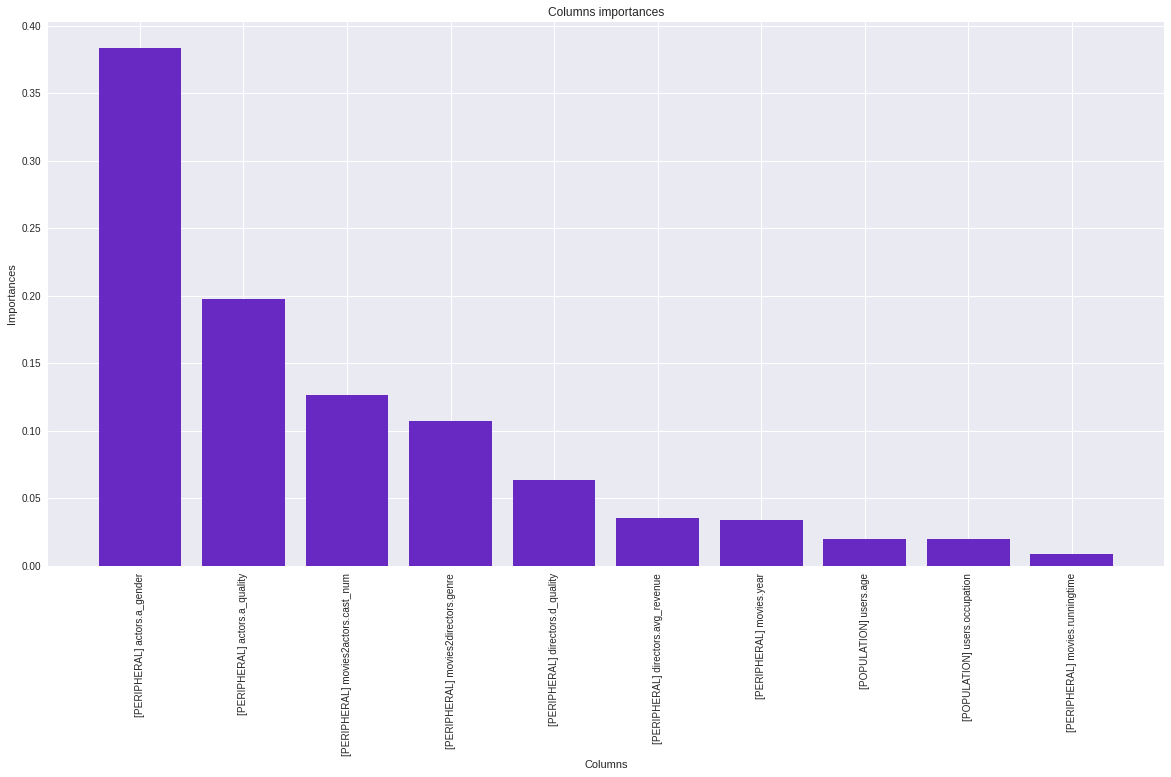

In [25]:
names, importances = pipe1.columns.importances()

plt.subplots(figsize=(20, 10))

plt.bar(names, importances, color='#6829c2')

plt.title('Columns importances')
plt.xlabel('Columns')
plt.ylabel('Importances')
plt.xticks(rotation='vertical')
plt.show()

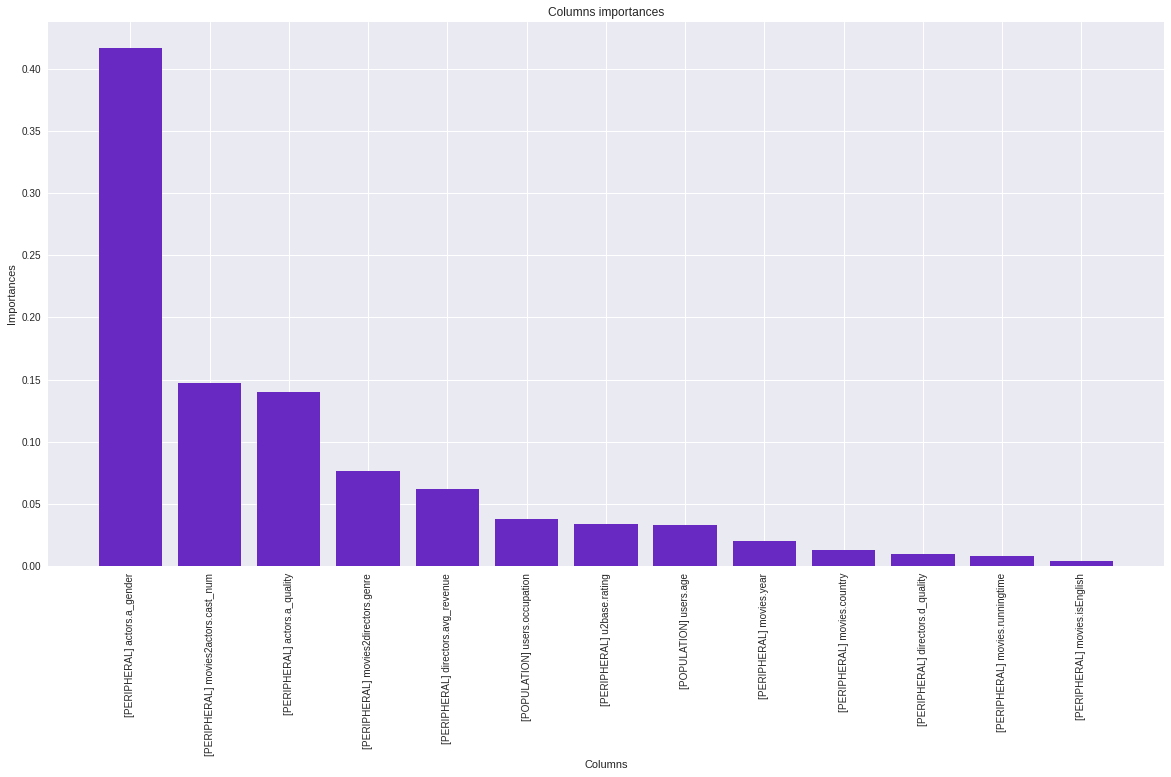

In [26]:
names, importances = pipe2.columns.importances()

plt.subplots(figsize=(20, 10))

plt.bar(names, importances, color='#6829c2')

plt.title('Columns importances')
plt.xlabel('Columns')
plt.ylabel('Importances')
plt.xticks(rotation='vertical')
plt.show()

### 2.7 Productionization

It is possible to productionize the pipeline by transpiling the features into production-ready SQL code. Please also refer to getML's `sqlite3` module.

In [28]:
# Creates a folder named movie_lens_pipeline containing
# the SQL code.
pipe2.features.to_sql().save("movie_lens_pipeline")

### 2.8 Benchmarks

State-of-the-art approaches on this dataset perform as follows:


| Approach                          | Study                       | Accuracy     | AUC     |
| :------------------------------   | :-------------------------  | -----------: | ------: |
| Probabalistic Relational Model    | Ghanem (2009)               | --           |  69.2%  |
| Multi-Relational Bayesian Network | Schulte and Khosravi (2012) | 69%          |  --     |
| Multi-Relational Bayesian Network | Schulte et al (2013)        | 66%          |  --     |


By contrast, getML's algorithms, as used in this notebook, perform as follows:

| Approach  | Accuracy     | AUC     |
| :-------- | -----------: | ------: |
| FastProp  | 77.8%        | 79.0%  |
| Relboost  | 81.6%        | 83.4%  |



## 3. Conclusion

In this notebook we have demonstrated how getML can be applied to the MovieLens dataset. We have demonstrated the our  approach outperforms state-of-the-art relational learning algorithms.

## Citations

Motl, Jan, and Oliver Schulte. "The CTU prague relational learning repository." arXiv preprint arXiv:1511.03086 (2015).

Ghanem, Amal S. "Probabilistic models for mining imbalanced relational data." Doctoral dissertation, Curtin University (2009).

Schulte, Oliver, and Hassan Khosravi. "Learning graphical models for relational data via lattice search." Machine Learning 88.3 (2012): 331-368.

Schulte, Oliver, et al. "A hierarchy of independence assumptions for multi-relational Bayes net classifiers." 2013 IEEE Symposium on Computational Intelligence and Data Mining (CIDM). IEEE, 2013.


# Next Steps

This tutorial went through the basics of applying getML to relational data. If you want to learn more about getML, here are some additional tutorials and articles that will help you:

__User Guides__ (from our [documentation](https://docs.getml.com/latest/)):
* [Feature learning with Multirel](https://docs.getml.com/latest/user_guide/feature_engineering/feature_engineering.html#multirel)
* [Feature learning with Relboost](https://docs.getml.com/latest/user_guide/feature_engineering/feature_engineering.html#relboost)


# Get in contact

If you have any question schedule a [call with Alex](https://go.getml.com/meetings/alexander-uhlig/getml-demo), the co-founder of getML, or write us an [email](team@getml.com). Prefer a private demo of getML? Just contact us to make an appointment.